# Import Modules

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from skimage import color
from skimage import io

import os
import glob
import skimage.transform
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve, RocCurveDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import pickle

random.seed(20)

In [2]:
# idx 210 - 3 gates
# idx 230 - 1 gate

idx = 210      # image index to display steps
feat_size = 16   # width and height of patch vector
n_points_corner = 20   # Number of points per corner
n_points_background = 200 # Number of total points in the background
n_samples = 2500 # Number of samples for evaluation image

# Load Data

In [3]:
def data_loader():

    # Obtain folder
    folder = os.getcwd()
    folder2 = os.path.abspath(os.path.join(folder, os.pardir))
    
    # Load images
    img_paths = glob.glob(os.path.join(folder2+'\images', 'img_*.png'))
    img_paths = sorted(img_paths) 
    
    print('Loaded', len(img_paths), 'images.')

    # Load corner annotations
    data = pd.read_csv(folder2+'\images\corners.csv')
    corners = pd.DataFrame(data)
    
    
    corners.columns = ['img_name', 'x_top_left', 'y_top_left', 'x_top_right', 'y_top_right', 
                    'x_bottom_right', 'y_bottom_right', 'x_bottom_left', 'y_bottom_left']
    img_names = corners['img_name']
    corners.index = img_names
    
    corners = corners.iloc[: , 1:]
    
    # Set out of bound values
    corners[corners>=360] = 360
    corners[corners<0] = 0
    
    # Put corners more on square boxed area
    corners['x_top_left'] -= 5
    corners['y_top_left'] -= 5  
    corners['x_top_right'] += 5
    corners['y_top_right'] -= 5
    corners['x_bottom_left'] -=5
    corners['y_bottom_left'] += 5
    corners['x_bottom_right'] += 5
    corners['y_bottom_right'] += 5
    
    return img_paths, corners

def image_name(img_path):
    
        # Return image name from path
        head, tail = os.path.split(img_path)
        return tail
    
def xy_corners(img_path, corners):
    # Obtain array with corner coordinates
    img_name = image_name(img_path)
    
    img_corners = np.array(corners.loc[img_name]) 
    
    # Find number of gates on one image
    num_gates = len(img_corners)
   
    img_corners2 = []
    if len(img_corners.shape) > 1:
        for i,gate in enumerate(img_corners):
            gate2 = gate.reshape(4,2)
            img_corners2.append(gate2)
       
    else: 
        
        img_corners2 = img_corners.reshape(4,2)
    
        
    img_corners2 = np.array(img_corners2)
    
    return img_corners2
    

In [4]:
def show_img(img_path, img_corners_all):
    
   # plot image with corners
    plt.figure()
    img = plt.imread(img_path) 
    plt.imshow(img)

    if len(img_corners_all.shape) > 2:  # if there is more than 1 gate
   
        x = img_corners_all[:,:,0]
        y = img_corners_all[:,:,1]
    
    else:
        x = img_corners_all[:,0]
        y = img_corners_all[:,1]

    plt.scatter(x,y, c = 'r')
    
    
    plt.show()

Loaded 308 images.


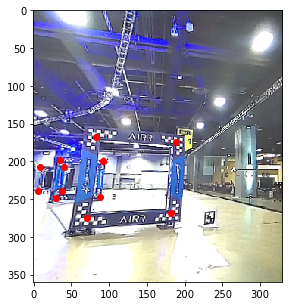

In [5]:
plt.rcParams["figure.figsize"] = (5,5)

# Visualize corner points on image
img_paths, corners = data_loader()
img_path = img_paths[idx]
img_corners_all = xy_corners(img_path, corners)

show_img(img_path, img_corners_all)  


# Generate Sample Points

In [6]:
def delete_edge_points(image, points, patch_dim):
    # Remove all points too close to the edge
    patch_dim = (patch_dim[0], patch_dim[1])
    
    points = points[points[:,0] > patch_dim[1],:]
    points = points[points[:,1] > patch_dim[0],:]
    points = points[points[:,0] < image.shape[1] - patch_dim[1],:]
    points = points[points[:,1] < image.shape[0] - patch_dim[0],:]

    return points

def get_background_points(image, n_points, patch_dim):
   
    # Obtain background points by randomly selecting a number of points from a grid.
    grid = np.array(np.meshgrid(np.linspace(0., image.shape[0], n_points),np.linspace(0., image.shape[1], n_points)))
    points = grid.reshape(2,-1).T

    # Delete points on the edges
    points = delete_edge_points(image, points, patch_dim)
    
    i = np.random.choice(points.shape[0], n_points, replace = False)
    points = points[i,:]
    
    return points

def get_corner_points(image, img_corners, n_points, patch_dim, dist):
    
    # Generate sample points around corners
    var = np.array((dist/3, dist/3)) / 10
    
    all_points = []
    
    for i, pt in enumerate(img_corners):
    
        points = np.random.randn(n_points, 2)
        points = pt + points * var 
        points = delete_edge_points(image, points, patch_dim)
        
        if len(points) == n_points:
            all_points.append(points)

    all_points = np.array(all_points)
    all_points = all_points.reshape(-1,2)
    
    return all_points

def change_label(background_points, corner_points, img_corners, thres):
    
    # Reassign labels, remove points on the border to make the classes better separable. 
    background_points2 = []
    corner_points2 = []
     
    for i, point in enumerate(corner_points):
        Append = False
        for n, corner in enumerate(img_corners):
            dist = np.sqrt(np.sum((point - corner)**2))
         
            if dist <= thres:
                Append = True

        if Append:
            corner_points2.append(point)
            
    for i, point in enumerate(background_points):
        Append = True    
        for n, corner in enumerate(img_corners):
            
            dist = np.sqrt(np.sum((point - corner)**2))
            
            if dist <= thres /3:
                Append = False

        if Append:
            background_points2.append(point)              
            
    return np.array(background_points2), np.array(corner_points2)


def comp_dist(img_corners):
    
    # Compute distance between top left and top right corner, used for scaling.  
    corner1 = img_corners[0]  # Top left
    corner2 = img_corners[1]  # Top right
    dist = np.sqrt(np.sum((corner1 - corner2)**2))
    
    return dist

def nearest_gate(img_corners_all):
    
    # Out of all gates in an image, find the nearest gate
    distlst = []
    
    # Check if there is more than one gate
    if np.prod(np.array(img_corners_all).shape) > 8:
        for i, img_corners in enumerate(img_corners_all):
            dist = comp_dist(img_corners)
            distlst.append(dist)
            
        # This is the gate with the largest distance between its top corners
        nearest_obst_idx = distlst.index(max(distlst))
        return img_corners_all[nearest_obst_idx]
                               
    else:
        # If there is only one gate, just return its corners
        return img_corners_all

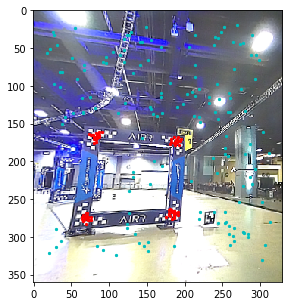

In [7]:
# Find the number of gates
if img_corners_all.shape[1] == 2:   
    n_gates = 1
else:
    n_gates = img_corners_all.shape[0]

# Find the nearest gate only to generate training patches
img_corners = nearest_gate(img_corners_all) 

img = plt.imread(img_path) 
dist = comp_dist(img_corners)
patch_dim = (feat_size, feat_size, 3)

# Get the sample points on the corners
corner_points = get_corner_points(img, img_corners, n_points_corner, patch_dim, dist)

# Get the sample points in the background.
background_points = get_background_points(img, n_points_background, patch_dim)

# Remove overlapping background samples and re-assign labels.
background_points, corner_points = change_label(background_points, corner_points, img_corners_all.reshape(-1,2), dist)

plt.scatter(corner_points[:,0], corner_points[:,1], s = 5, c = 'r')
plt.scatter(background_points[:,0], background_points[:,1], s = 5, c = 'c')

plt.imshow(img)
plt.show()


# Get Patches

In [8]:
def get_patch_at_point(image, point, feat_size): 
    
    # Obtain the patch around each sample point. 
    feat_window = (feat_size, feat_size, 3)
    
    # Get 32x32 window (for feat_size = 16)
    top = int(point[0] - feat_size)
    bottom = int(point[0] + feat_size)
    left = int(point[1] - feat_size)
    right = int(point[1] + feat_size)
    
    # Check if all patch points lie inside image
    assert(top >= 0 and bottom >= 0 and left >= 0 and right >= 0)
    assert(top < bottom and left < right)
    
    patch = image[left:right, top:bottom, :]
    
    # Resize to 16x16 patches
    patch = skimage.transform.resize(patch, feat_window, anti_aliasing=False)
    
    return patch


def plot_patches(background_points, corner_points, n_patch_plots, feat_size):
    # Display some patches
    
    idx_background = np.random.choice(background_points.shape[0], n_patch_plots, replace = False)
    idx_corners = np.random.choice(corner_points.shape[0], n_patch_plots, replace = False)

    patch_corners = corner_points[idx_corners]
    patch_background = background_points[idx_background]

    for i, point in enumerate(patch_corners):
        plt.subplot(2,10,i+1)
        patch = get_patch_at_point(img, patch_corners[i], feat_size)
        plt.imshow(patch)
        plt.xticks([])
        plt.yticks([])

    for i, point in enumerate(patch_background):
        plt.subplot(2,10,i+1+n_patch_plots)
        patch = get_patch_at_point(img, patch_background[i], feat_size)
        plt.imshow(patch)
        plt.xticks([])
        plt.yticks([])
        
def get_patches(points_arr, img, feat_size):
    # Get an array of all patches
    patch_lst = []
    
    for i, point in enumerate(points_arr):
        patch = get_patch_at_point(img, point, feat_size)
        patch_lst.append(patch.flatten())
        
    return np.array(patch_lst)


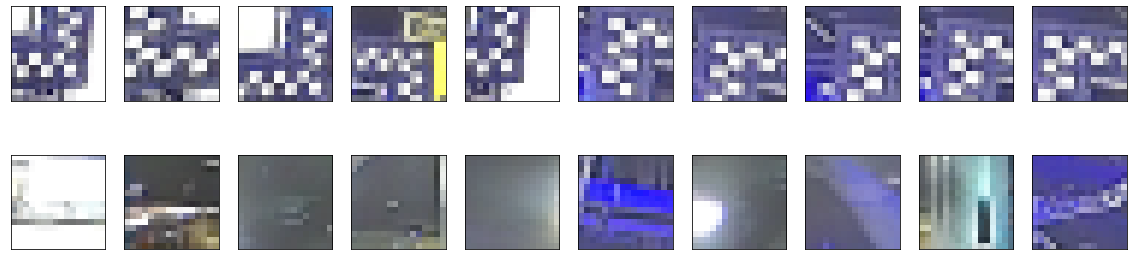

In [9]:
# Plot patches

n_patch_plots = 10

plt.rcParams["figure.figsize"] = (20,5)
plot_patches(background_points, corner_points, n_patch_plots, feat_size)

corner_patches = get_patches(corner_points, img, feat_size)
background_patches = get_patches(background_points, img, feat_size)   

corner_labels = np.ones(corner_patches.shape[0])
background_labels = np.zeros(background_patches.shape[0])

# Get Training and Test Data

In [10]:
def get_data_per_image(img_path, corners, n_points_background, n_points_corner, feat_size):
    
    # Obtain corner annotations
    img_corners_all = xy_corners(img_path, corners)
    
    # Find corners of nearest gate
    img_corners = nearest_gate(img_corners_all) # Only consider nearest obstacle
    
    img = plt.imread(img_path)
    
    dist = comp_dist(img_corners)

    patch_dim = (feat_size, feat_size, 3)

    # Obtain the sample points at the corners
    corner_points = get_corner_points(img, img_corners, n_points_corner, patch_dim, dist)
    
    # Obtain the sample points in the background
    background_points = get_background_points(img, n_points_background, patch_dim)
    
    # Make classes better seperable
    background_points, corner_points = change_label(background_points, corner_points, img_corners, dist)

    # Obtain patches at points
    corner_patches = get_patches(corner_points, img, feat_size)
    background_patches = get_patches(background_points, img, feat_size)   

    # Change labels, corner = 1, background = 0
    corner_labels = np.ones(corner_patches.shape[0])
    background_labels = np.zeros(background_patches.shape[0])

    # Put patches in arrays for training.
    X_train = np.concatenate([corner_patches, background_patches])    # patches
    y_train = np.concatenate([corner_labels, background_labels])      # labels
    points_train = np.concatenate([corner_points, background_points]) # Sample point locations [x,y]

    return X_train, y_train, points_train

In [11]:
# Debugging
random.seed(20)
img_path = img_paths[idx]
X_train, y_train, points_train = get_data_per_image(img_path, corners, n_points_background, n_points_corner, feat_size)

### Load All Data Patches

In [12]:
# Load all patches, labels and patch sample points for all images into one big array

img_paths, corners = data_loader()

X_train = []
y_train = []
points_train = []

X_test = []
y_test = []
points_test = []

# Training set
for i, img_path in enumerate(img_paths[1:240]):   # neglects the first image because of a bug, considering the time vs gain, it was decided not to fix this.
    i_n = i + 1

    if i_n % 15 == 0:
        print(' ', int(i_n / len(img_paths[1:]) * 100), '%')
    else:
        print("=",  end = '')
 
        
    X_train_img, y_train_img, points_train_img = get_data_per_image(img_path, corners, n_points_background, n_points_corner, feat_size)
    
    for i, patch in enumerate(X_train_img):
        X_train.append(patch)
        
    for i, label in enumerate(y_train_img):
        y_train.append(label)
        
    for i, point in enumerate(points_train_img):
        points_train.append(point)
    

# Test set   
for i, img_path in enumerate(img_paths[240:]):
    i = i + 240
  

    if i % 15 == 0:
        print(' ', int(i / len(img_paths[1:]) * 100), '%')
    else:
        print("=",  end = '')
    
    X_test_img, y_test_img, points_test_img = get_data_per_image(img_path, corners, n_points_background, n_points_corner, feat_size)
    
    for i, patch in enumerate(X_test_img):
        X_test.append(patch)
        
    for i, label in enumerate(y_test_img):
        y_test.append(label)
        
    for i, point in enumerate(points_test_img):
        points_test.append(point)
    
print('        100 %')



Loaded 308 images.
==============  4 %
==============  9 %
==============  14 %
==============  19 %
==============  24 %
==============  29 %
==============  34 %
==============  39 %
==============  43 %
==============  48 %
==============  53 %
==============  58 %
==============  63 %
==============  68 %
==============  73 %
==============  78 %
==============  83 %
==============  87 %
==============  92 %
==============  97 %
=======        100 %


# Machine Learning Classifiers

In [13]:
def print_accuracy_confusion(y_test, y_pred, clf_name=''):
    print(clf_name, 'accuracy score:', accuracy_score(y_test, y_pred))
    print(clf_name, 'confusion matrix:\n', confusion_matrix(y_test, y_pred))


In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)
idxs = np.random.choice(X_train.shape[0], replace=False, size = 10000)

In [15]:
scaler = StandardScaler()

sX_train = scaler.fit_transform(X_train)
sX_test = scaler.transform(X_test)

sX_train_batch = sX_train[idxs]
y_train_batch = y_train[idxs]

In [16]:
rs = 22

rf_clf = RandomForestClassifier(random_state = rs)
dt_clf = DecisionTreeClassifier(random_state = rs)
sgd_clf = SGDClassifier(random_state = rs)
svm_clf = SVC(kernel = 'linear', random_state = rs)
et_clf = ExtraTreesClassifier(random_state = rs)
kn_clf = KNeighborsClassifier(n_neighbors = 2)

In [17]:
folder = os.getcwd()
save_path = folder+'\\models'
if not os.path.exists(save_path):
        os.makedirs(save_path)

## Random Forest

In [18]:
%%time
rf_clf.fit(X_train, y_train)
y_rf_train_predict = rf_clf.predict(X_train)
print_accuracy_confusion(y_train, y_rf_train_predict, 'Train')

Train accuracy score: 1.0
Train confusion matrix:
 [[39642     0]
 [    0 18120]]
Wall time: 4min 48s


In [19]:
%%time
y_rf_test_predict = rf_clf.predict(X_test)
print_accuracy_confusion(y_test, y_rf_test_predict, 'Test')

Test accuracy score: 0.964867922017433
Test confusion matrix:
 [[9416  233]
 [ 295 5085]]
Wall time: 534 ms


In [20]:
with open(save_path+'\\rf_clf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

## Decision Tree

In [21]:
%%time
dt_clf.fit(X_train, y_train)
y_dt_train_predict = dt_clf.predict(X_train)
print_accuracy_confusion(y_train, y_dt_train_predict, 'Train')

Train accuracy score: 1.0
Train confusion matrix:
 [[39642     0]
 [    0 18120]]
Wall time: 1min 16s


In [22]:
%%time 
y_dt_test_predict = dt_clf.predict(X_test)
print_accuracy_confusion(y_test, y_dt_test_predict, 'Test')

Test accuracy score: 0.8516867389713221
Test confusion matrix:
 [[8896  753]
 [1476 3904]]
Wall time: 76.8 ms


In [23]:
with open(save_path+'\\dt_clf.pkl', 'wb') as f:
    pickle.dump(dt_clf, f)

## Extra Trees

In [24]:
%%time
et_clf.fit(X_train, y_train)
y_et_train_predict = et_clf.predict(X_train)
print_accuracy_confusion(y_train, y_et_train_predict, 'Train')

Train accuracy score: 1.0
Train confusion matrix:
 [[39642     0]
 [    0 18120]]
Wall time: 53 s


In [25]:
%%time
y_et_test_predict = et_clf.predict(X_test)
print_accuracy_confusion(y_test, y_et_test_predict, 'Test')

Test accuracy score: 0.9702575021624859
Test confusion matrix:
 [[9433  216]
 [ 231 5149]]
Wall time: 571 ms


In [26]:
with open(save_path+'\\et_clf.pkl', 'wb') as f:
    pickle.dump(et_clf, f)

## SGD

In [27]:
%%time
sgd_clf.fit(sX_train, y_train)
y_sgd_train_predict = sgd_clf.predict(sX_train)
print_accuracy_confusion(y_train, y_sgd_train_predict, 'Train')

Train accuracy score: 0.8344067033689969
Train confusion matrix:
 [[35105  4537]
 [ 5028 13092]]
Wall time: 12.1 s


In [28]:
%%time
y_sgd_test_predict = sgd_clf.predict(sX_test)
print_accuracy_confusion(y_test, y_sgd_test_predict, 'Test')

Test accuracy score: 0.7519462372746024
Test confusion matrix:
 [[8519 1130]
 [2598 2782]]
Wall time: 70.8 ms


In [29]:
with open(save_path+'\\sgd_clf.pkl', 'wb') as f:
    pickle.dump(sgd_clf, f)

## Linear SVM

In [30]:
%%time
svm_clf.fit(sX_train_batch, y_train_batch)
y_svm_train_predict = svm_clf.predict(sX_train)
print_accuracy_confusion(y_train, y_svm_train_predict, 'Train')

Train accuracy score: 0.8299747238669021
Train confusion matrix:
 [[35554  4088]
 [ 5733 12387]]
Wall time: 6min 14s


In [31]:
%%time
y_svm_test_predict = svm_clf.predict(sX_test)
print_accuracy_confusion(y_test, y_svm_test_predict, 'Test')

Test accuracy score: 0.7483531838445672
Test confusion matrix:
 [[8623 1026]
 [2756 2624]]
Wall time: 47.7 s


In [32]:
with open(save_path+'\\svm_clf.pkl', 'wb') as f:
    pickle.dump(svm_clf, f)

## K-Neighbors

## ROC Curve

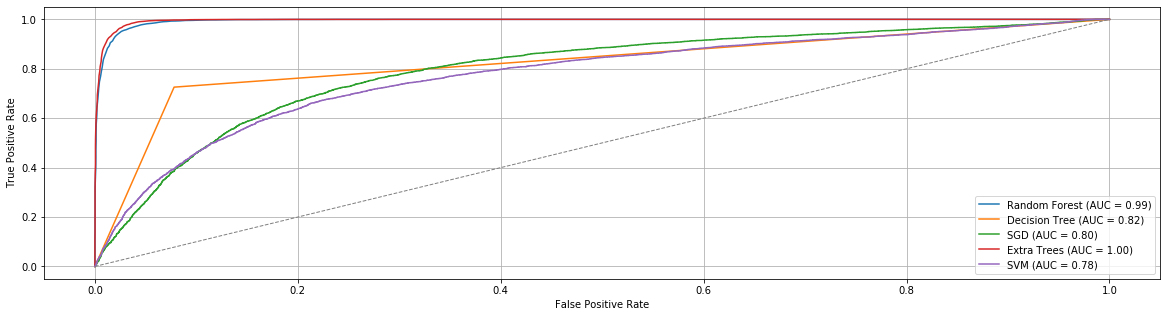

In [33]:
rf_disp = plot_roc_curve(rf_clf, X_test, y_test, name = 'Random Forest')
dt_disp = plot_roc_curve(dt_clf, X_test, y_test, ax = rf_disp.ax_, name='Decision Tree')
sgd_disp = plot_roc_curve(sgd_clf, X_test, y_test, ax=dt_disp.ax_, name='SGD')
et_disp = plot_roc_curve(et_clf, X_test, y_test, ax=sgd_disp.ax_, name='Extra Trees')
svm_disp = plot_roc_curve(svm_clf, X_test, y_test, ax=et_disp.ax_, name='SVM')
#kn_disp = plot_roc_curve(kn_clf, X_test, y_test, ax=svm_disp.ax_, name='KN')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.grid(True)
plt.show()

# Corner Detection

## Load Model

In [34]:
with open(save_path+'\\et_clf.pkl', 'rb') as f:
    clf = pickle.load(f)

## Obtain Patches in Sample Points

In [35]:
def get_patches_eval(points_arr, img):
    
    # Get patches for one image
    patch_lst = []
    
    for i, point in enumerate(points_arr):
        patch_lst.append(get_patch_at_point_eval(img, point))
        
    return np.array(patch_lst)

def get_patch_at_point_eval(image, point): 
    
    # Get patch at point
    top = int(point[0] - feat_size/2)
    bottom = int(point[0] + feat_size/2)
    left = int(point[1] - feat_size/2)
    right = int(point[1] + feat_size/2)
    
    patch = image[left:right, top:bottom, :]
    return patch.flatten()




In [36]:
%%time
# Obtain sample points for evaluation image
img = plt.imread(img_paths[idx]) 

img_resize = skimage.transform.resize(img, (img.shape[0] // 2, img.shape[1] // 2), anti_aliasing=False)
img_size_x = img_resize.shape[1]
img_size_y = img_resize.shape[0]

Xgrid = np.linspace(feat_size//2, img_size_x - feat_size//2, int(np.sqrt(n_samples)))
Ygrid = np.linspace(feat_size//2, img_size_y - feat_size//2, int(np.sqrt(n_samples)))

grid = np.array(np.meshgrid(Xgrid, Ygrid))
points = grid.reshape(2,-1).T

Wall time: 17 ms


In [37]:
# Show sampled points
def show_points(points, img):
    
    x_tar = np.mean(points[:,0])
    y_tar = np.mean(points[:,1])
    plt.figure()
    plt.imshow(img)
    plt.scatter(points[:,0], points[:,1], s = 40, c = 'r')
    plt.axis('off')

    return plt


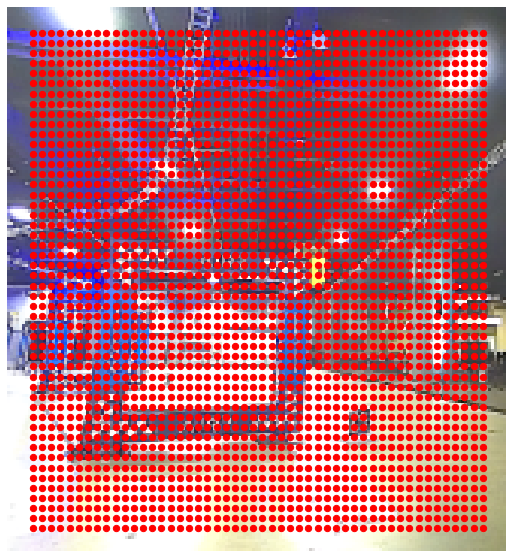

In [38]:
plt.rcParams["figure.figsize"] = (10, 10)
fig = show_points(points, img_resize)

In [39]:
%%time

# Obtain evaluation data and transform
X_data = get_patches_eval(points, img_resize)


Wall time: 26.8 ms


(16, 16, 3)


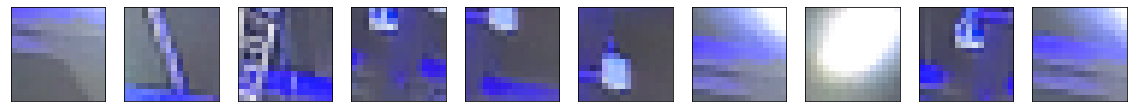

In [40]:
plt.rcParams["figure.figsize"] = (20,20)

# Show patches
for i in range(10):
        i_n = np.random.choice(len(img_paths),1, replace = False)
        plt.subplot(1,10,i+1)
        patch = X_data[i_n].reshape(feat_size, feat_size, 3)
        plt.imshow(patch)
        plt.xticks([])
        plt.yticks([])
print(patch.shape)

## Evaluate Model on Patches 

In [41]:
%%time

# Filter outliers with DBscan
y_data = clf.predict(X_data)
corner_points = points[y_data == 1]*2

db = DBSCAN(eps=16, min_samples=6).fit(corner_points)
labels = db.labels_
corner_points_no_noise = corner_points[labels != -1]


Wall time: 114 ms


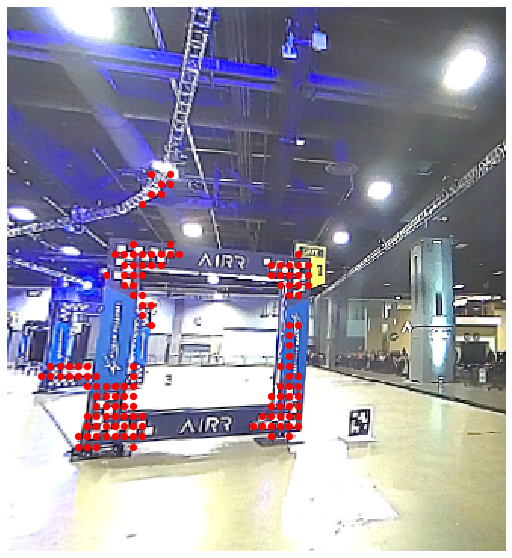

In [42]:
plt.rcParams["figure.figsize"] = (10, 10)
plt1 = show_points(corner_points_no_noise, img)


In [43]:
def eval_img(idx, img_paths, n_samples, feat_size):

    # Find all points on gate
    img = plt.imread(img_paths[idx]) 
    img_resize = skimage.transform.resize(img, (img.shape[0] // 2, img.shape[1] // 2), anti_aliasing=False)
    
    # Reshape
    img_size_x = img_resize.shape[1]
    img_size_y = img_resize.shape[0]

    # Create grid points
    Xgrid = np.linspace(feat_size/2, img_size_x - feat_size/2, int(np.sqrt(n_samples)))
    Ygrid = np.linspace(feat_size/2, img_size_y - feat_size/2, int(np.sqrt(n_samples)))

    grid = np.array(np.meshgrid(Xgrid, Ygrid))
    points = grid.reshape(2,-1).T

    # Put in data vector for evaluation
    X_data = get_patches_eval(points, img_resize)
    
    # Obtain labels from CNN
    y_data = clf.predict(X_data)
    gate_points = points[y_data == 1]*2
    
    # Filter outliers
    db = DBSCAN(eps=16, min_samples=6).fit(gate_points)
    labels = db.labels_ 
    gate_points_no_noise = gate_points[labels != -1]
    
    return gate_points_no_noise



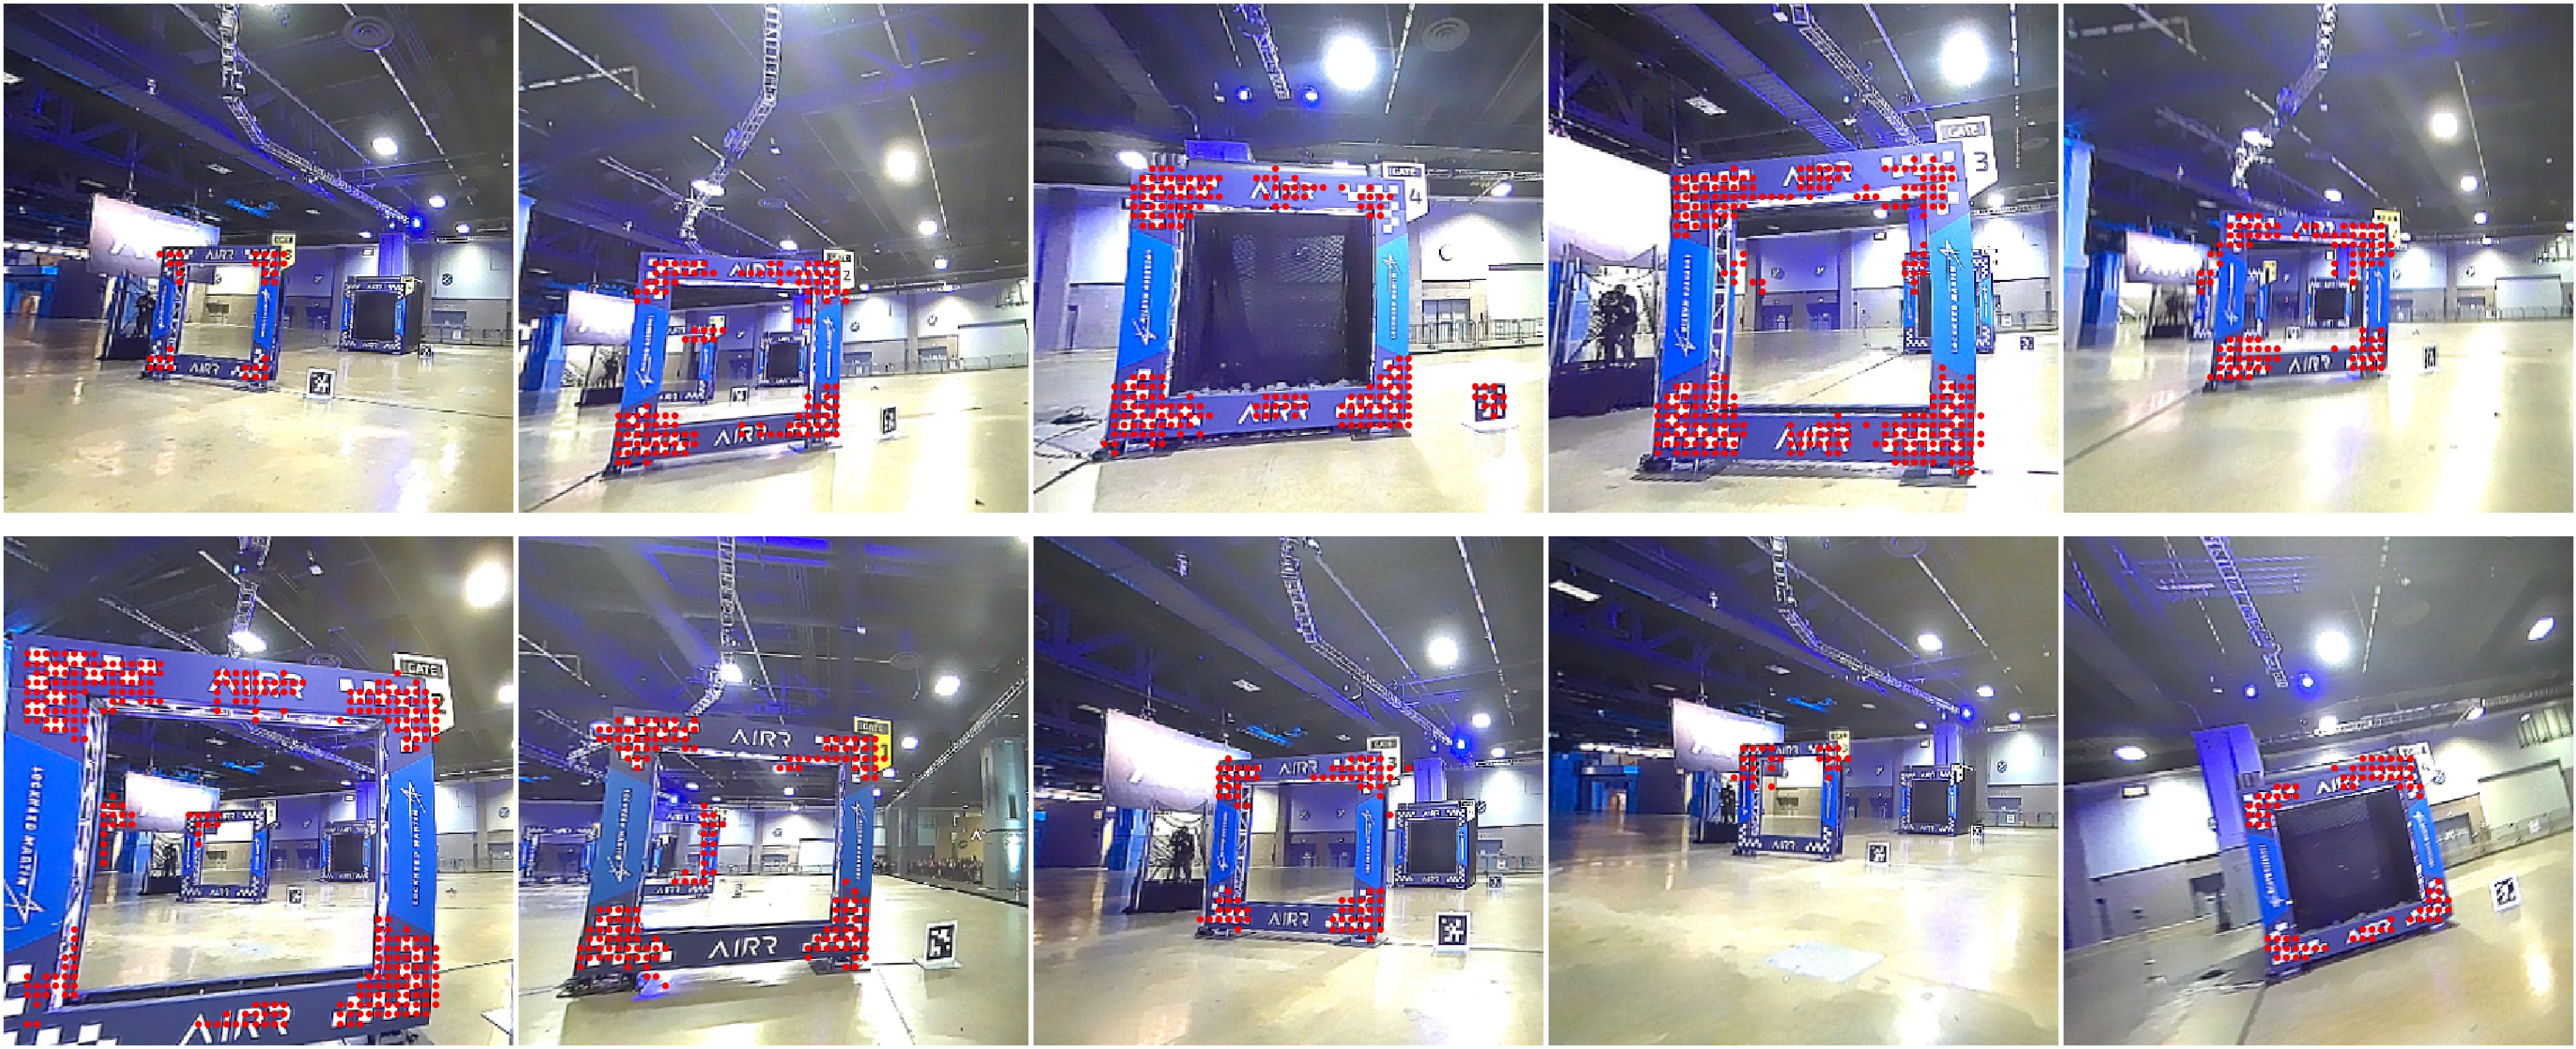

In [47]:
def fig_to_img(fig):
    # Save figure on disc
    fig.savefig("fig.jpg", bbox_inches='tight',pad_inches = 0)
    img = plt.imread("fig.jpg")
    return img

def crop_square(img):
    # Crop image to a square, centered in the middle
    y = img.shape[0]
    x = img.shape[1]
    square = np.max([x, y])
    start_x = x//2-square//2
    start_y = y//2-square//2    
    return img[start_y:start_y+square,start_x:start_x+square]

for i, i_n in enumerate(np.random.choice(len(img_paths),10, replace = False)):
        plt.rcParams["figure.figsize"] = (10,10)   
        img = plt.imread(img_paths[i_n]) 
        img = crop_square(img)
        gate_points = eval_img(i_n, img_paths, n_samples, feat_size)
        print("=",  end = '')
        
        plt1 = show_points(gate_points, img)
        img1 = fig_to_img(plt1)
        plt1.close()
        
        plt.rcParams["figure.figsize"] = (70,30)   
        plt.subplot(2, 5, i+1)
        plt.imshow(img1)
        plt.axis('off')
    
plt.tight_layout()
plt.savefig("fig.jpg", bbox_inches='tight',pad_inches = 0)

In [45]:
def correct_detected(idx, img_paths, corners):
    # Compute the number of correct detected obstacles
    
    img_path = img_paths[idx]
    img_corners_all = xy_corners(img_path, corners)
    corners_real = nearest_gate(img_corners_all)
    gate_points = eval_img(idx, img_paths, n_samples, feat_size)

    dim = 20
    corners_detected = 0
   
    for i, corner in enumerate(corners_real):
        x_c = corner[0]
        y_c = corner[1]

        points_on_corner = gate_points[gate_points[:,0] < x_c + dim]
        points_on_corner = points_on_corner[points_on_corner[:,0] > x_c - dim]

        points_on_corner = points_on_corner[points_on_corner[:,1] < y_c + dim]
        points_on_corner = points_on_corner[points_on_corner[:,1] > y_c - dim]


        if points_on_corner.shape[0] >= 6:
            corners_detected += 1

    if corners_detected >= 3:
        correct_detected = 1
        
    else:
        correct_detected = 0

    return gate_points, correct_detected

In [46]:
acc = 0

# Set plot size
plt.rcParams["figure.figsize"] = (10, 10)
plt.tight_layout()

# Create folder to store evaluation images
folder = str(os.getcwd())
a =  str(folder+'\\perf_evaluation\\')
if not os.path.exists(a):
        os.makedirs(a)

# Evaluate model on all images in the folder
for i in range(1, len(img_paths)):
    img_path = img_paths[i]
    img_name = image_name(img_path)
    X = plt.imread(img_path)
    gate_points, success = correct_detected(i, img_paths, corners)
    
    acc += success
    
    plt.imshow(X)
    plt.scatter(gate_points[:,0], gate_points[:,1], c = 'r', s = 40)
    plt.axis('off')      
    
    # Label it based on correct prediction
    if success:
         k = str('T_')
    else: 
        k = str('F_')
    
    # Save image
    b =  str(a+k+'_idx'+str(i)+'_'+img_name)
    plt.savefig(b, bbox_inches='tight',pad_inches = 0)
    plt.close()
    
     # Print progress
    if i % 15 == 0 and i != 0:
        print(' ', int(i / len(img_paths) * 100), '%')
    elif i == 0:
        print('Start Evaluation')
    else:
        print("=",  end = '')
        
    
print( '\n')
print( '******************************************************')
print('Predicted ', acc, ' out of', len(img_paths)-1, 'nearest obstacles correctly. \n')
print('Accuracy:', np.round(acc/(len(img_paths)-1), 3 ) )
print( '******************************************************')


==============  4 %
==============  9 %
==============  14 %
==============  19 %
==============  24 %
==============  29 %
==============  34 %
==============  38 %
==============  43 %
==============  48 %
==============  53 %
==============  58 %
==============  63 %
==============  68 %
==============  73 %
==============  77 %
==============  82 %
==============  87 %
==============  92 %
==============  97 %

******************************************************
Predicted  287  out of 307 nearest obstacles correctly. 

Accuracy: 0.935
******************************************************
